# Logistic Regression

Logistic Regression is a linear classification algorithm used to estimate the probability of a finite set of outcomes for a given set of features. In logistic regression, a sigmoid curve is fit to the data using maximum likelihood estimation (MLE). MLE tests different values of coefficients for each feature over multiple iterations to minimize the error between the predicted and actual values of the target variable. Once the optimal coefficient for each feature is determined through MLE (this state is referred to as 'convergence'), the logistic function uses a linear combination of the features and applies the sigmoid function (which describes the sigmoid curve) to produce a predicted probability (y^) given an observation (x).


This notebook applies Scikit-learn's logistic regression model, which implements regularized logistic regression by default. It does so because logistic regression can be prone to overfitting, especially when a large number of features are included in analysis. Overfitting can be addressed through regularization -- in the case of logistic regression, a process in which features with large coefficients are reduced or eliminated according to a specific penalty function in order to reduce the complexity of the model. It's important to note that regularization can reduce the effects of overfitting, but it may not reduce those effects entirely. 

In later steps, a logistic regression model is defined, features are selected, and hyperparameters are tuned using cross-validated grid search to yield the highest performing model possible given a define set of hyperparameters. Various measures are applied to assess model performance. and These steps are explained in greater detail below.

In [2480]:
%%capture
%run preprocessing.ipynb

In [2481]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
)
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
)

In [2482]:
random_state = 0

In [2483]:
clf = LogisticRegression(max_iter=5000, random_state=random_state)

## Feature Selection

There are 26 features after preprocessing. Recall that some features were excluded prior to applying preprocessing transformations. This isn't a huge number of features, but it may be enough to confound analysis by the model leading to lower accuracy or a less generalizable model (an overfit model) or both. At some point, adding more feature inputs in logistic regression can increase the likelihood that the model will overfit. This is why it's important to apply some degree of feature selection before model training -- reducing the number of features to only those that are most important to the problem will produce a more generalizable model.

In this case,the feature selection method I've chosen to implement is `Cross-validated Recursive Feature Elimination` (Scikit-learn's RFECV) using a random forest classifier as an estimator. Recursive Feature Elimination works by fitting the model and removing the least informative feature or features and repeating until the desired/optimal number of features is reached. With cross-validation, this process is repeated k times and an optimal set of features is selected based upon a scoring algorithm (i.e. accuracy, error, or some other measure).

I've chosen a `random forest classifier` (Scikit-learn's RandomForestClassifier) as an estimator for its advantages in determining feature importances. A random forest is an ensemble of decision trees. It uses random sampling of data with replacement (bagging) and and feature randomness (feature bagging) to create a forest of uncorrelated decision trees. As bagged decision trees are created, the reduction in the error function for each selected feature is calculated at each split. The greater the reduction in the error function for a given feature, the more important the feature. Evaluating feature importance across all decision trees provides a robust way of determining which subset of features is most informative of the target and which are relatively unimportant.

Feature selection alone may not be enough to prevent overfitting but the hope is that in combination with model tuning a performant, generalizable model will be achieved. Feature selection steps are carried out in the code cell immediately below.

In [2484]:
input_features = X_test.columns

estimator = RandomForestClassifier(n_jobs=-1, random_state=random_state)
selector = RFECV(estimator, n_jobs=-1, scoring='roc_auc')

X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

selected = selector.get_feature_names_out(input_features=input_features)
data = {
    'Feature Name': input_features,
    'Selected': [(f in selected) for f in input_features],
}
df_selected = pd.DataFrame(data, columns=data.keys()).sort_values(by=['Feature Name']).reset_index(drop=True)
display(df_selected.style.apply(lambda i: ['background-color: gray']*len(i) if i['Selected'] else '', axis=1))

,Feature Name,Selected
0,Age,True
1,CabinDeck_A,False
2,CabinDeck_B,False
3,CabinDeck_C,False
4,CabinDeck_D,False
5,CabinDeck_E,False
6,CabinDeck_F,False
7,CabinDeck_G,True
8,CabinDeck_T,False
9,CabinLocation_Aft,False


This selection method has reduced the number of features from 26 to 12. The selected features are highlighted above.

## Tune

`Grid Search` is a model tuning method used to find the combination of hyperparameters that yields the best performing model. A hyperparameter is an input to the model that is set before the model is trained -- it is external to the model and cannot be estimated, whereas parameters are internal to the model and can be estimated (e.g. beta coefficients in logistic regression). Hyperparameters may have a significant impact on how the model learns, and therefore how the model performs.

We'll implement Grid Search using Scikit-learn's GridSearchCV class. GridSearchCV trains the model over multiple iterations with various combinations of hyperparameters and tests the performance of each distinct combination using k-fold cross-validation. Once all the hyperparameter combinations have been tested, we can determine which combination yielded the best performing model.

 It's worth noting that sometimes fine tuning a model with grid search can lead to overfitting, so it's especially important to look for signs of overfitting when evaluating model performance. Another downside of grid search is that it is resource-intensive because all combinations of parameters are tried and - in the case of GridSearchCV - cross-validated.

Two of the most important hyperparameters for logistic regression are `solver` and `penalty`. We'll tune these hyperparameters below to find the optimal solver/penalty combination and inverse of regularization strength (to prevent overfitting to the extent possible). It's important to note that not all solvers and penalties are compatible with one another.

From Scikit Learn Docs:

>The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:
>
>    ‘lbfgs’ - [‘l2’, None]
>
>    ‘liblinear’ - [‘l1’, ‘l2’]
>
>    ‘newton-cg’ - [‘l2’, None]
>
>    ‘newton-cholesky’ - [‘l2’, None]
>
>    ‘sag’ - [‘l2’, None]
>
>    ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]

source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

This solver/penalty compatibility will necessarily influence how we construct the hyperparameter combinations we'll test. I've tried to express this clearly in the code cell below.

In [2485]:
params = [
    {
        'n_jobs': [None],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'C': [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1],
    },
    {
        'n_jobs': [-1],
        'penalty': ['l1', 'l2'],
        'solver': ['saga'],
        'C': [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1],
    },
    {
        'n_jobs': [-1],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
        'C': [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1],
    },
]

search = GridSearchCV(
    clf,
    params,
    scoring='roc_auc',
)

search.fit(X_train, y_train)

clf.set_params(**search.best_params_)

LogisticRegression(C=0.01, max_iter=5000, random_state=0, solver='liblinear')

## Train & Predict

In [2486]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Evaluate

Assessing model performance can be tricky. Certain evaluation metrics are more suited to different types of models than others. Futhermore, there can be many underlying factors that can conflate measurements and confuse interpretation of results. That being the case, it's important to use multiple metrics to assess model performance, and to chose the metrics best suited to the type of model employed.

The `accuracy` score for the model is a simple calculation of the number of correct predictions out of the total number of predictions. It tends to be a good metric of model performance when data is balanced. But assessing a model by the proportion of correct predictions alone can be misleading. Any model could be subject to the 'Accurary Paradox'. The Accuracy Paradox describes a phenomenon in which a model with higher accuracy has less predictive power than a model with lower accuracy. This can be caused by imbalanced data and/or overfitting, among other causes. Therefore, it's also important to consider other factors. We can also assess a model by its `precision` and `recall`. Precision is a measure of the accuracy of the model's positive predictions that penalizes false-positives; and recall measures what proportion of those postive cases the model actually identified as positive -- it penalizes false-negatives. These are often considered together as the `F1` score, which is the harmonic mean of precision and recall.

Another reliable way to assess the performance of a classification model is to calculate `ROC AUC`. The ROC (Receiver Operating Characteristics) Curve plots the relationship between the true-positive rate (y-axis) and the false-positive rate (x-axis) at various classification thresholds. The Area Under Curve is a measure of class separability -- it tells us how well the model performs at distinguishing between classes. A ROC AUC score of 0.5 (lowest score) means the model has very little or no ability to distinguish between classes; and a score of 1.0 (highest score) means the model performs perfectly at distinguishing between classes. ROC AUC is a good metric when data is imbalanced.

Here's a summary of how these various metrics are calculated:

- **Accuracy:**
    - Number of correct predictions out of the total number of predictions
    - Beware of the accuracy paradox
    - A poor metric for imbalanced data
    - (true-positive + true-negative) / total observations
>
- **Precision:**
    - Accuracy of positive predictions.
    - Prefer when minimizing false-positives is the priority
    - true-positive / (true-positive + false-postive)
>
- **Recall:**
    - Proportion of positive cases the model actually identified as positive
    - Prefer when minimizing false-negatives is the priority
    - true-positive / (true-positive + false-negative)
>
- **F1:**
    - Harmonic mean of precision and recall
    - Prefer when minimizing all false predictions is the priority
    - 2 * precision * recall / (precision + recall)
>
- **ROC AUC:**
    - A measure of class separability
    - Measures how well the model performs at distinguishing between classes
    - A good metric for imbalanced data

Before applying these metrics, it can help to get a sense of the distribution of the model's predictions. A confusion matrix can help vizualize the distribution. Scikit-learn's confusion_matrix function is used below to report the distribution of true-positive, false-positive, false-negative, and true-negative predictions.

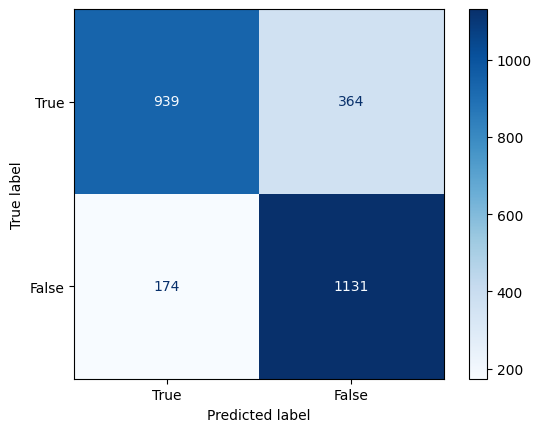

In [2487]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['True', 'False'], cmap=plt.cm.Blues)

Using these figures and the formulas above, we could calculate each metric manually; but let's just use Scikit-learn's convenient classification_report function.

In [2488]:
clf_report = classification_report(y_test, y_pred, target_names=['Transported (False)', 'Transported (True)'], digits=4)
print(clf_report)

roc_auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"ROC AUC: {roc_auc_score:.4f}")

                     precision    recall  f1-score   support

Transported (False)     0.8437    0.7206    0.7773      1303
 Transported (True)     0.7565    0.8667    0.8079      1305

           accuracy                         0.7937      2608
          macro avg     0.8001    0.7937    0.7926      2608
       weighted avg     0.8001    0.7937    0.7926      2608

ROC AUC: 0.8817


`K-Fold Cross-validation` can provide even more confidence in the above metrics. K-fold cross-validation works by dividiing the dataset into 'k' number of subsets (folds), and then trains and tests the model over 'k' rounds. During each round, the model is trained on all but one subset (k-1), and the remaining subset is used as a test set to produce an accuracy score for that round. We can get a good sense of model performance by evaluating the average accuracy and ROC AUC accross all cross-validations performed.

In [2489]:
train_accuracy = cross_val_score(clf, X=X_train, y=y_train, scoring='accuracy')
train_roc_auc = cross_val_score(clf, X=X_train, y=y_train, scoring='roc_auc')

test_accuracy = cross_val_score(clf, X=X_test, y=y_test, scoring='accuracy')
test_roc_auc = cross_val_score(clf, X=X_test, y=y_test, scoring='roc_auc')

accuracies = f"K-fold CV Accuracies: {train_accuracy.mean():.4f} (train) | {test_accuracy.mean():.4f} (test)"
roc_aucs = f"K-fold CV ROC AUCs: {train_roc_auc.mean():.4f} (train) | {test_roc_auc.mean():.4f} (test)"
print(f"{accuracies}\n{roc_aucs}")

K-fold CV Accuracies: 0.7975 (train) | 0.7983 (test)
K-fold CV ROC AUCs: 0.8822 (train) | 0.8775 (test)


Overall the model performs well at distinguishing between classes with a ROC AUC score of about 0.88 for both the training and test sets. The accuracy score is roughly 80% for both the training and test sets. Because accuracy and ROC AUC scores are very similar between test and training sets, we can be reasonably confident that the model is not overfitting. The F1 score is very similar to the accuracy score at nearly 80%. The model is better at predicting true-negatives than true-positives. The false-positive rate is higher than the false-negative rate as indicated by the precision and recall scores respectively (you can see it plainly in the confusion matrix as well). There might be more useful features that can be engineered from the dataset, but those really should be supported by strong hypotheses or domain knowledge. It might be the case that a different type of model might be more suited to the problem, but the model performs well nonetheless.